In [11]:
import numpy as np
import SoccerNet as sn
import torch
import matplotlib.pyplot as plt
from SoccerNet.Downloader import SoccerNetDownloader
mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="./Data")
import cv2

In [12]:
lines_coords = [[[0., 54.16, 0.], [16.5, 54.16, 0.]],
                [[16.5, 13.84, 0.], [16.5, 54.16, 0.]],
                [[16.5, 13.84, 0.], [0., 13.84, 0.]],
                [[88.5, 54.16, 0.], [105., 54.16, 0.]],
                [[88.5, 13.84, 0.], [88.5, 54.16, 0.]],
                [[88.5, 13.84, 0.], [105., 13.84, 0.]],
                [[0., 37.66, -2.44], [0., 30.34, -2.44]],
                [[0., 37.66, 0.], [0., 37.66, -2.44]],
                [[0., 30.34, 0.], [0., 30.34, -2.44]],
                [[105., 37.66, -2.44], [105., 30.34, -2.44]],
                [[105., 30.34, 0.], [105., 30.34, -2.44]],
                [[105., 37.66, 0.], [105., 37.66, -2.44]],
                [[52.5, 0., 0.], [52.5, 68, 0.]],
                [[0., 68., 0.], [105., 68., 0.]],
                [[0., 0., 0.], [0., 68., 0.]],
                [[105., 0., 0.], [105., 68., 0.]],
                [[0., 0., 0.], [105., 0., 0.]],
                [[0., 43.16, 0.], [5.5, 43.16, 0.]],
                [[5.5, 43.16, 0.], [5.5, 24.84, 0.]],
                [[5.5, 24.84, 0.], [0., 24.84, 0.]],
                [[99.5, 43.16, 0.], [105., 43.16, 0.]],
                [[99.5, 43.16, 0.], [99.5, 24.84, 0.]],
                [[99.5, 24.84, 0.], [105., 24.84, 0.]]]

In [13]:
circle_coords = [[52.5, 34],[11,34],[94, 34]]
circle_coords = np.array(circle_coords)

In [14]:
circle_coords[:,0]

array([52.5, 11. , 94. ])

In [15]:
lines_coords = np.array(lines_coords)

In [16]:
def project(frame, P):
    new_lines = []
    for line in lines_coords:
        w1 = line[0]
        w2 = line[1]
        i1 = P @ np.array([w1[0]-105/2, w1[1]-68/2, w1[2], 1])
        i2 = P @ np.array([w2[0]-105/2, w2[1]-68/2, w2[2], 1])
        i1 /= i1[-1]
        i2 /= i2[-1]
        new_line = [i1,i2]
        new_lines += [new_line]
        print(new_line)
        frame = cv2.line(frame, (int(i1[0]), int(i1[1])), (int(i2[0]), int(i2[1])), (255, 0, 0), 3)

    r = 9.15
    pts1, pts2, pts3 = [], [], []
    base_pos = np.array([11-105/2, 68/2-68/2, 0., 0.])
    for ang in np.linspace(37, 143, 50):
        ang = np.deg2rad(ang)
        pos = base_pos + np.array([r*np.sin(ang), r*np.cos(ang), 0., 1.])
        ipos = P @ pos
        ipos /= ipos[-1]
        pts1.append([ipos[0], ipos[1]])

    base_pos = np.array([94-105/2, 68/2-68/2, 0., 0.])
    for ang in np.linspace(217, 323, 200):
        ang = np.deg2rad(ang)
        pos = base_pos + np.array([r*np.sin(ang), r*np.cos(ang), 0., 1.])
        ipos = P @ pos
        ipos /= ipos[-1]
        pts2.append([ipos[0], ipos[1]])

    base_pos = np.array([0, 0, 0., 0.])
    for ang in np.linspace(0, 360, 500):
        ang = np.deg2rad(ang)
        pos = base_pos + np.array([r*np.sin(ang), r*np.cos(ang), 0., 1.])
        ipos = P @ pos
        ipos /= ipos[-1]
        pts3.append([ipos[0], ipos[1]])

    XEllipse1 = np.array(pts1, np.int32)
    XEllipse2 = np.array(pts2, np.int32)
    XEllipse3 = np.array(pts3, np.int32)
    frame = cv2.polylines(frame, [XEllipse1], False, (255, 0, 0), 3)
    frame = cv2.polylines(frame, [XEllipse2], False, (255, 0, 0), 3)
    frame = cv2.polylines(frame, [XEllipse3], False, (255, 0, 0), 3)

    return frame, new_lines

In [17]:
P = [[ 3.63012504e+03,  9.79367218e+02,  6.91838515e+01, -1.05309533e+05],
 [-1.16540985e+02,  3.34528792e+02,  3.71743635e+03,  4.87286272e+04],
 [ 3.88544208e-01, -9.04717296e-01,  1.74699779e-01,  9.90950047e+01]]

In [18]:
P_smol = [[P[0][0], P[0][1], P[0][3]],
          [P[1][0], P[1][1], P[1][3]],
          [P[2][0], P[2][1], P[2][3]]]

In [34]:
def get_new_lines(lines_coords):
    new_lines = []
    unscaled_new_lines = []
    for line in lines_coords:
        w1 = line[0]
        w2 = line[1]
        i1 = P @ np.array([w1[0]-105/2, w1[1]-68/2, w1[2], 1])
        i2 = P @ np.array([w2[0]-105/2, w2[1]-68/2, w2[2], 1])
        #print(f'w1: {w1}')
        #print(f'i1: {i1}')
        unscaled_line = [i1,i2]
        
        unscaled_new_lines += [unscaled_line]

        scaled_i1 = i1/i1[-1]
        scaled_i2 = i2/i2[-1]
        #print(f'i1 after scaling: {scaled_i1}')
        new_line = [scaled_i1, scaled_i2]
        new_lines += [new_line]
    #print(unscaled_new_lines)
    return new_lines, unscaled_new_lines

In [89]:
def get_original_lines(new_lines, unscaled_lines):
    original_lines = []
    
    for it,new_line in enumerate(new_lines):
        scale1 = unscaled_lines[it][0][2]
        scale2 = unscaled_lines[it][1][2]
        
        i1 = new_line[0]
        i2 = new_line[1]
        
        print(f'i1 before scaling: {i1}')
        #i1 *= scale1
        #i2 *= scale2
        P_inv = np.linalg.inv(np.array(P_smol))
        
        w1 = P_inv @ np.array(i1)
        w2 = P_inv @ np.array(i2)
        
        w1[0] += 105/2
        w2[0] += 105/2
        w1[1] += 68/2
        w2[1] += 68/2
        
        print(f'i1: {i1}')
        print(f'w1: {w1}')
        og_line = [w1, w2]
        original_lines += [og_line]

    return original_lines

In [90]:
# from minimap to camera pov
def transform_point(point):
    unscaled_point = P @ np.array([point[0] - 105/2, point[1] - 68/2, 0, 1])
    return unscaled_point


# from camera pov to minimap
def get_map_point(point, unscaled_point):
    

SyntaxError: incomplete input (1075147324.py, line 9)

In [91]:
img = 'No-Bells-Just-Whistles/examples/messi_sample.png'

In [92]:
messi = cv2.imread(img)

In [93]:
output,new_lines = project(messi,P)

[array([-4.56763539e+03,  1.01875366e+03,  1.00000000e+00]), array([-3.23396813e+03,  8.92324045e+02,  1.00000000e+00])]
[array([-2.47456898e+03,  4.46846250e+02,  1.00000000e+00]), array([-3.23396813e+03,  8.92324045e+02,  1.00000000e+00])]
[array([-2.47456898e+03,  4.46846250e+02,  1.00000000e+00]), array([-3.25613453e+03,  4.96236274e+02,  1.00000000e+00])]
[array([475.72067348, 540.6512267 ,   1.        ]), array([1.03714996e+03, 4.87428590e+02, 1.00000000e+00])]
[array([ 42.8788651 , 287.75938929,   1.        ]), array([475.72067348, 540.6512267 ,   1.        ])]
[array([ 42.8788651 , 287.75938929,   1.        ]), array([475.76210847, 260.40389254,   1.        ])]
[array([-3.90181043e+03,  6.27021727e+02,  1.00000000e+00]), array([-3.67294842e+03,  5.46105994e+02,  1.00000000e+00])]
[array([-3.87750826e+03,  7.43798885e+02,  1.00000000e+00]), array([-3.90181043e+03,  6.27021727e+02,  1.00000000e+00])]
[array([-3.65179837e+03,  6.53873406e+02,  1.00000000e+00]), array([-3.67294842e

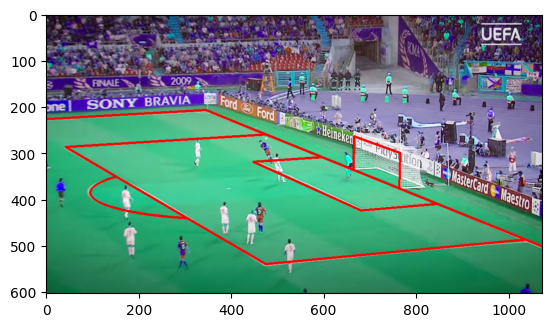

In [94]:
plt.imshow(messi)

In [95]:
messi.shape

(603, 1073, 3)

In [96]:
len(new_lines)

23

In [97]:
def plot_map(lines, points, P = None):
    if P is not None:
        lines,unscaled_lines = get_new_lines(lines)
        
        unscaled_points = [transform_point(point) for point in points]
        scaled_points = [upoint / upoint[-1] for upoint in unscaled_points]
        scaled_points = np.array(scaled_points)
        print(points[2])
        print(unscaled_points[2])
        print(scaled_points[2])
        for i,line in enumerate(lines):
            x1,y1,_ = line[0]
            x2,y2,_ = line[1]
            plt.plot((x1,x2),(-y1,-y2))
            plt.ylim((-603,0))
            plt.xlim((0,1073))
        plt.scatter(scaled_points[:,0], -scaled_points[:,1])
    else:
        for i,line in enumerate(lines):
            x1,y1,_ = line[0]
            x2,y2,_ = line[1]
            plt.plot((x1,x2),(y1,y2))
        points = np.array(points)
        plt.scatter(points[:,0], points[:,1])

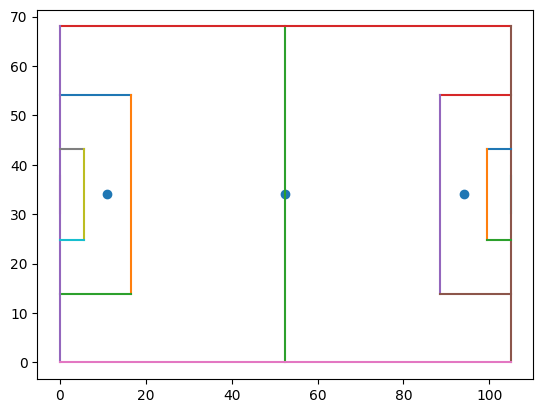

In [98]:
plot_map(lines_coords, circle_coords)

[94. 34.]
[45340.65616    43892.1763225    115.21958933]
[393.51516893 380.94369696   1.        ]


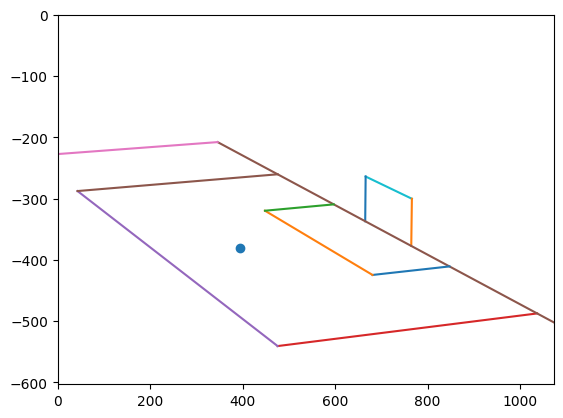

In [99]:
plot_map(lines_coords, circle_coords, P)

/tmp/ipykernel_322738/2331684996.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


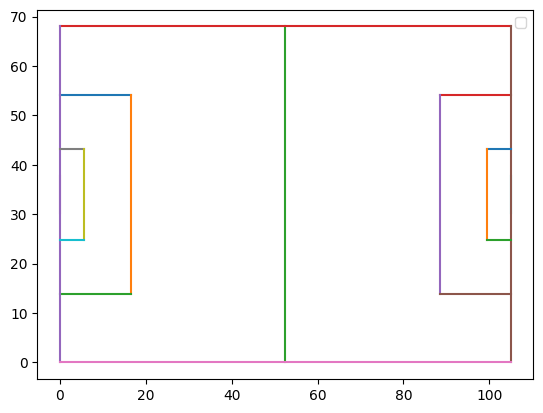

In [100]:
for i,line in enumerate(lines_coords):
    x1,y1,_ = line[0]
    x2,y2,_ = line[1]
    plt.plot((x1,x2),(y1,y2))
    plt.legend()

/tmp/ipykernel_322738/507544583.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


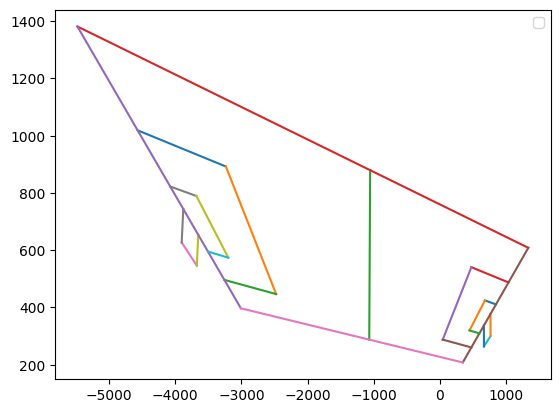

In [101]:
for i,line in enumerate(new_lines):
    x1,y1,_ = line[0]
    x2,y2,_ = line[1]
    plt.plot((x1,x2),(y1,y2))
    plt.legend()

/tmp/ipykernel_93919/236461029.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


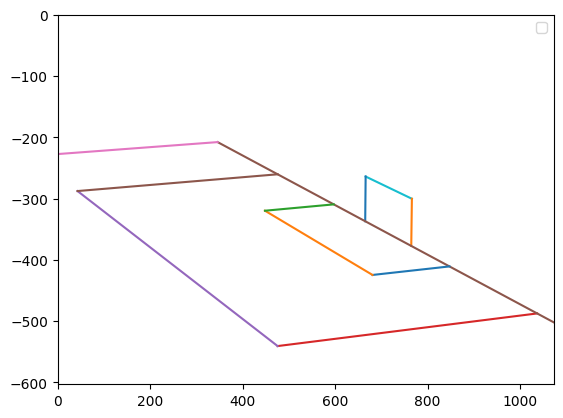

In [72]:
for i,line in enumerate(new_lines):
    x1,y1,_ = line[0]
    x2,y2,_ = line[1]
    plt.plot((x1,x2),(-y1,-y2))
    plt.ylim((-603,0))
    plt.xlim((0,1073))
    plt.legend()

In [103]:
new_lines,unscaled_new_lines = get_new_lines(lines_coords)

In [104]:
og_lines = get_original_lines(new_lines, unscaled_new_lines)

i1 before scaling: [-4.56763539e+03  1.01875366e+03  1.00000000e+00]
i1: [-4.56763539e+03  1.01875366e+03  1.00000000e+00]
w1: [5.16316190e+01 3.43334583e+01 1.65405907e-02]
i1 before scaling: [-2.47456898e+03  4.46846250e+02  1.00000000e+00]
i1: [-2.47456898e+03  4.46846250e+02  1.00000000e+00]
w1: [5.21516573e+01 3.38049281e+01 9.67618512e-03]
i1 before scaling: [-2.47456898e+03  4.46846250e+02  1.00000000e+00]
i1: [-2.47456898e+03  4.46846250e+02  1.00000000e+00]
w1: [5.21516573e+01 3.38049281e+01 9.67618512e-03]
i1 before scaling: [475.72067348 540.6512267    1.        ]
i1: [475.72067348 540.6512267    1.        ]
w1: [5.28795727e+01 3.42125607e+01 1.05436856e-02]
i1 before scaling: [ 42.8788651  287.75938929   1.        ]
i1: [ 42.8788651  287.75938929   1.        ]
w1: [5.27741360e+01 3.38464839e+01 7.61488790e-03]
i1 before scaling: [ 42.8788651  287.75938929   1.        ]
i1: [ 42.8788651  287.75938929   1.        ]
w1: [5.27741360e+01 3.38464839e+01 7.61488790e-03]
i1 before 

/tmp/ipykernel_322738/2467467050.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


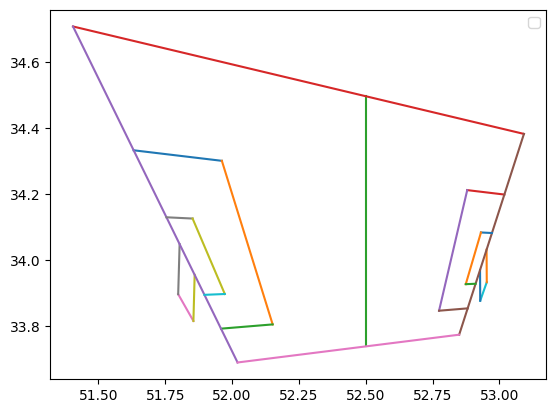

In [105]:
for i,line in enumerate(og_lines):
    x1,y1,_ = line[0]
    x2,y2,_ = line[1]
    plt.plot((x1,x2),(y1,y2))
    plt.legend()